# **EMOTION DETECTOR**

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


# Exploring Dataset

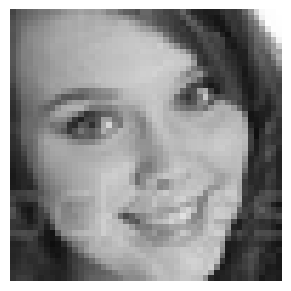

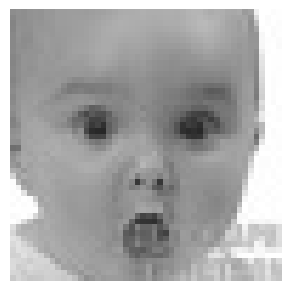

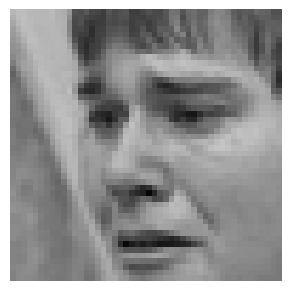

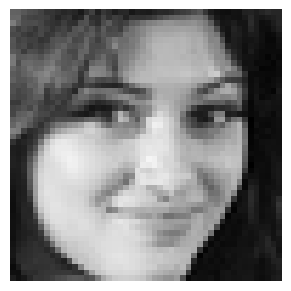

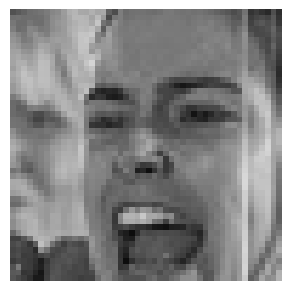

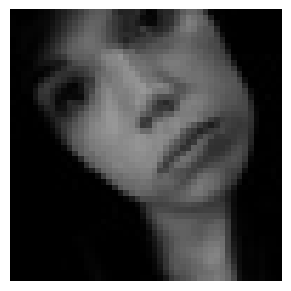

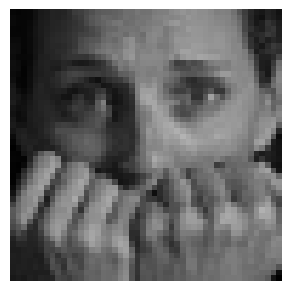

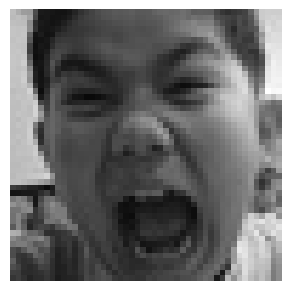

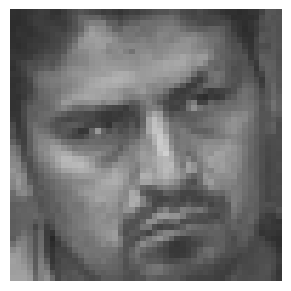

In [2]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image)); plt.axis('off')

# Preparing Data for Training

In [3]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size, img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)


datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size, img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Defining Model

In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x


In [5]:
def Dense_f (input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x


In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(inputs, 64, (5,5))
    conv_3 = Convolution(inputs, 128, (3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten, 256)
    output = Dense(7, activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])

    model.compile (loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    return model 

In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 128)       0     

# Initializing the Model

In [8]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only= True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

# Training the Model

In [9]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks    
)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6562 - accuracy: 0.3733
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 302s 671ms/step - loss: 1.6562 - accuracy: 0.3733 - val_loss: 1.8175 - val_accuracy: 0.2673
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3567 - accuracy: 0.4858
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 290s 647ms/step - loss: 1.3567 - accuracy: 0.4858 - val_loss: 1.4805 - val_accuracy: 0.4291
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.1942 - accuracy: 0.5509
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 286s 639ms/step - loss: 1.1942 - accuracy: 0.5509 - val_loss: 1.4238 - val_accuracy: 0.4600
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.0585 - accuracy: 0.6089
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 

# Model Evalutaion

In [10]:
model.evaluate(validation_generator)

113/113 [==============================] - 12s 105ms/step - loss: 1.9679 - accuracy: 0.4946


[1.967862606048584, 0.49456673860549927]

# Plotting Loss

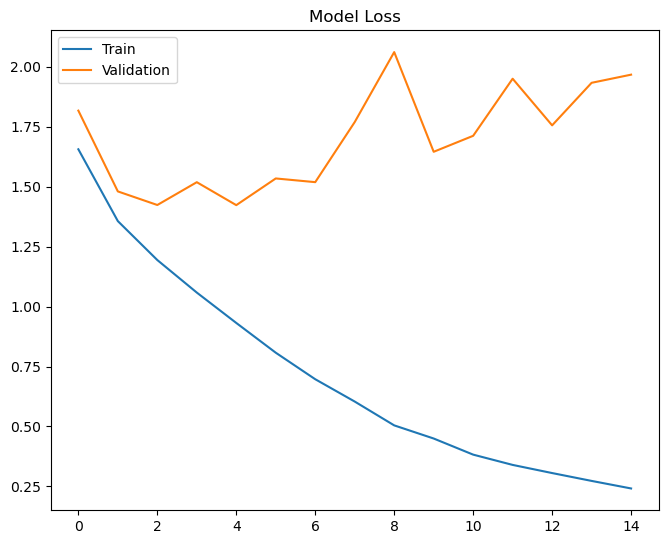

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

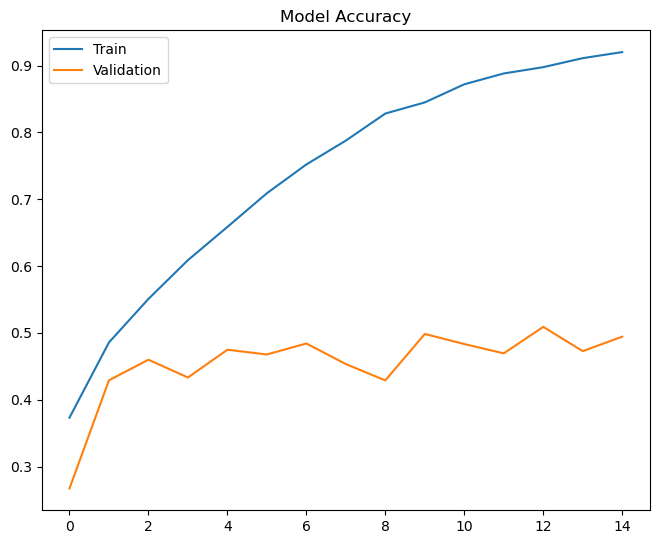

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

# Saving Model

In [19]:
model_json = model.to_json()
with open ("model_a.json", "w") as json_file:
    json_file .write (model_json)